In [38]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import pandas as pd
import numpy as np

import gc

import warnings
warnings.simplefilter('ignore')

%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg' 

from datetime import datetime, timedelta

from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

# importing NLP features: 
from nltk.corpus import stopwords
from nltk import ngrams
from tqdm import tqdm

import string 
punc = string.punctuation 

import regex as re
from pymystem3 import Mystem
m = Mystem()

from mxnet import gluon
from mxnet import nd
import gluonnlp as nlp
import re

from sklearn.metrics import log_loss
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import scipy.sparse
from scipy.sparse import hstack, csr_matrix

import lightgbm as lgb

from collections import defaultdict

#import spacy
#import textacy

import multiprocessing as mp
from multiprocessing import cpu_count, Pool, current_process

import contextlib

In [39]:
df_train = pd.read_csv('/home/biclast/data_nvme_ln/dataset/quora/train.csv', index_col='id')
#df_test = pd.read_csv('/home/jose/data_science_test/quora/all/test.csv',index_col='test_id')
#df_sample = pd.read_csv('/home/jose/data_science_test/quora/all/sample_submission.csv')

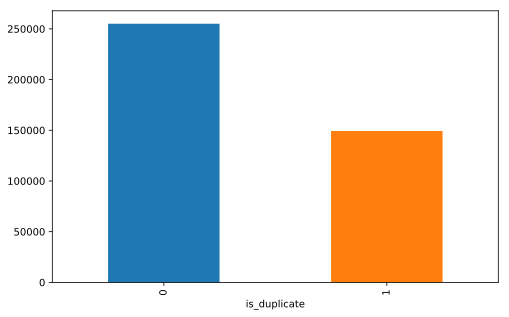

In [40]:
df_train.groupby("is_duplicate")['question1'].count().plot.bar()

In [41]:
#calculate percentage of missing data
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

missing_data(df_train)

,Total,Percent
question2,2,0.000495
question1,1,0.000247
is_duplicate,0,0.000000
qid2,0,0.000000
qid1,0,0.000000


In [42]:
df_train.head()

,qid1,qid2,question1,question2,is_duplicate
id,,,,,
0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [43]:
def avg_word_length(text):
    words = text.split()
    return (sum(len(word) for word in words) / len(words))

def clean_text(text, punc, stopwords, mystem):    
    line = re.sub('[{}]'.format(punc), ' ', text).strip().lower().split()
    words = [word for word in line if word not in stopwords]
    words_lemm = list(map(lambda x: mystem.lemmatize(x)[0], words))
    cleaned_text = " ".join(words_lemm)
    return cleaned_text

In [44]:
df_train['question1'].fillna('', inplace=True)
df_train['question2'].fillna('', inplace=True)

In [45]:
#define stopwords
#english_stopwords = set(stopwords.words('english'))
english_stopwords = {'a', 'the'}
#english_stopwords = {'a','the','at','in','will', "'ll", "'re", "are""}

In [46]:
num_cores = cpu_count()
num_partitions = 16

def parallel_procession(func, df):
    df_split = np.array_split(df, num_partitions)
    #pool = Pool(num_cores)

    with contextlib.closing( Pool(num_cores) ) as pool:
        #list_df = pool.map(func, df_split)
        df = pd.concat(pool.map(func, df_split, chunksize=2))
    #df = pd.concat(list_df)
    #pool.close()
    #pool.join()
    ##pool = None
    return df


In [47]:
def clean_dataframe(df):
    
    #print('Current process in clean_dataframe is {}'.format(current_process().pid))
    #print('df = ', df)
    text_cols = ["question1", "question2"]
    for col in tqdm(text_cols):
        df[col] = [clean_text(text, punc, english_stopwords, m) for text in df[col]]
    
    return df

In [48]:
%time df_train = parallel_procession(clean_dataframe, df_train)

100%|██████████| 2/2 [00:22<00:00, 11.00s/it]

100%|██████████| 2/2 [00:21<00:00, 10.99s/it]


CPU times: user 1.01 s, sys: 547 ms, total: 1.56 s
Wall time: 45.7 s


In [49]:
print(df_train[(df_train.question1 == '') & (df_train.question2 == '')].shape)
print(df_train[(df_train.question1 == '') | (df_train.question2 == '')].shape)
df_train[(df_train.question1 == '') | (df_train.question2 == '')]

(0, 5)
(18, 5)


,qid1,qid2,question1,question2,is_duplicate
id,,,,,
3306,6553,6554,,why is cornell s endowment lowest in ivy league,0
13016,25026,25027,,why should one not work at google,0
20794,39204,39205,,what is gmail tech support help phone number,0
47056,84067,84068,is there anywhere in world offering pain manag...,,0
96725,161071,161072,,who are moses noah and exodus,0
104101,171925,171926,,problem of solving problem is not problem but ...,0
105780,174363,174364,how can i develop android app,,0
134403,214814,214815,,what is your take on undercover report that hi...,0
158778,247989,48850,,do men forgive their wives when they cheat on ...,0


In [50]:
#df_train['question1'].fillna('None', inplace=True)
df_train['question1'] = ['NAN' if len(text.strip()) == 0 else text.strip() for text in df_train.question1]

#df_train['question2'].fillna('None', inplace=True)
df_train['question2'] = ['NAN' if len(text.strip()) == 0 else text.strip() for text in df_train.question2]

In [51]:
df_train[(df_train.question1 == '') | (df_train.question2 == '')].shape

(0, 5)

In [52]:
#log_loss(df_train['is_duplicate'], np.zeros_like(df_train['is_duplicate']) + df_train['is_duplicate'].mean())

In [53]:
#train_qs = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist()).astype(str)

In [54]:
#qmarks = np.mean(train_qs.apply(lambda x: '?' in x))
#math = np.mean(train_qs.apply(lambda x: '[math]' in x))
#fullstop = np.mean(train_qs.apply(lambda x: '.' in x))
#fullstop

In [142]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        if len(word2vec)>0:
            self.dim=len(word2vec[next(iter(word2vec))])
        else:
            self.dim=0
            
    def vectorizing(self, word):
        vector = np.zeros(self.dim)
        if word in self.word2vec: 
            vector = self.word2vec[word]        
        return vector            
            
    def fit(self, X):
        return self 
    
    def transform(self, X):
        return np.array([np.sum([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0) for words in X])

    def svd(self, X, cos_flag=False):
        
        reduced = []
        
        for string in X:
            
            l = np.array([self.vectorizing(w) for w in string])                      
                   
            if cos_flag:
                if (l.shape[0] > 2):
                    sv = TruncatedSVD(n_components=2).fit_transform(l.T).T
                    cos = np.dot(sv[0,:], sv[1,:])/(np.linalg.norm(sv[0,:])*np.linalg.norm(sv[1,:]))
                else:
                    cos = 0.
            
                reduced.append(cos)
                               
            else:
                if (l.shape[0] > 1):
                    reduced.append(TruncatedSVD(n_components=1).fit_transform(l.T).flatten())
                else:
                    reduced.append(l.flatten())
        
        return np.array(reduced)
    
    def convol_1(self, X):
        reduced = []
        for string in X:
            prod = 1
            norm = 1
            for word in string:
                if word in self.word2vec:
                    prod *= self.word2vec[word]
                    norm *= np.linalg.norm(self.word2vec[word])            
            conv = np.sum(prod)/norm
            reduced.append(conv)
        return np.array(reduced)
    
    def convol_2(self, X):
        reduced = []
        for string in X:
            prod = 1
            #norm = 1
            for word in string:
                if word in self.word2vec:
                    prod *= self.word2vec[word]
                    #norm *= np.linalg.norm(self.word2vec[word])
            if np.linalg.norm(prod) == 0:
                conv = 0.0
            else:
                conv = np.sum(prod)/np.linalg.norm(prod)
            if np.isnan(conv): conv = 0.
            reduced.append(conv)
        return np.array(reduced)
    
    def convol(self, X):
        reduced = []
        for string in X:
            prod = 1
            #norm = 1
            for word in string:
                if word in self.word2vec:
                    prod *= self.word2vec[word]
                    #norm *= np.linalg.norm(self.word2vec[word])            
            conv = np.sum(prod)
            reduced.append(conv)
        return np.array(reduced)

In [56]:
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        if len(word2vec)>0:
            self.dim=len(word2vec[next(iter(word2vec))])
        else:
            self.dim=0
        
    def fit(self, X):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent as any of the known words - so the default idf is the max of known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(lambda: max_idf, [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
        return self
    
    def transform(self, X):
        return np.array([np.mean([self.word2vec[w] * self.word2weight[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0) for words in X])

In [57]:
def cos_vec(mat1, mat2):
    
    cos = np.sum(mat1*mat2,axis=1)/(np.linalg.norm(mat1,axis=1)*np.linalg.norm(mat2,axis=1))
    cos[np.isnan(cos)] = 0.0
    cos[np.abs(cos) > 1.0] = 1.0
    
    return cos

In [58]:
fasttext_en = nlp.embedding.create('fasttext', source='wiki.en')

In [59]:
fast_dict = {word: vec for word, vec in zip(fasttext_en.idx_to_token, fasttext_en.idx_to_vec.asnumpy())}

In [144]:
ft_vec = MeanEmbeddingVectorizer(fast_dict)

In [24]:
#tfidf_vec = TfidfEmbeddingVectorizer(fast_dict)

In [25]:
#tfidf_vec.fit([v.split() for v in df_train.question1])

In [61]:
gc.collect()

420

In [62]:
#q1_tfidf = parallel_transform(tfidf_vec.transform,[v.split() for v in df_train.question1[:2]])

#q1_tfidf = tfidf_vec.transform([v.split() for v in df_train.question1])
#q2_tfidf = tfidf_vec.transform([v.split() for v in df_train.question2])

In [63]:
#del fasttext_en
gc.collect()

0

In [64]:
df_train.head()

,qid1,qid2,question1,question2,is_duplicate
id,,,,,
0,1,2,what is step by step guide to invest in share ...,what is step by step guide to invest in share ...,0
1,3,4,what is story of kohinoor koh i noor diamond,what would happen if indian government stole k...,0
2,5,6,how can i increase speed of my internet connec...,how can internet speed be increased by hacking...,0
3,7,8,why am i mentally very lonely how can i solve it,find remainder when math 23 24 math is divided...,0
4,9,10,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,0


In [120]:
num_partitions = 32

In [159]:
from functools import partial

def cover_func(df_list):
    q = current_func(df_list)
    return q
    
def parallel_transform(df):
    
    #def cover_func(sub_df):
        #q1 = func([v.split() for v in sub_df.question1[:2]])
        #q2 = func([v.split() for v in sub_df.question2[:2]])
        #return q1 #, q2 
    
    q1_split = np.array_split([v.split() for v in df.question1], num_partitions)
    q2_split = np.array_split([v.split() for v in df.question2], num_partitions)     
    
    #cover = partial(cover_func, func=fun)
    
    with contextlib.closing( Pool(num_cores) ) as p:
        vec1 = np.concatenate(p.map(cover_func, q1_split), axis=0)
        vec2 = np.concatenate(p.map(cover_func, q2_split), axis=0)
        
        #vec1 = p.map_async(cover_func, q1_split, chunksize=4)
        #vec2 = p.map_async(cover_func, q2_split, chunksize=4)
        
        #vec1.wait()
        #vec2.wait()
    #vec1 = map(cover, df_list)
    #pool2.close()
    #pool2.join()
    p = None
    
    return vec1, vec2 #np.vstack(vec1.get()), np.vstack(vec2.get())

In [140]:
current_func = ft_vec.transform

%time q1_transform, q2_transform = parallel_transform(df_train)
#q1 = ft_vec.svd([v.split() for v in df_train.question1[:2]])
#2 = ft_vec.svd([v.split() for v in df_train.question2])

#q1 = ft_vec.transform([v.split() for v in df_train.question1[:3]])
#q1 = ft_vec.transform(df_split[0])
#q1.shape
#np.vstack(map(ft_vec.convol,df_split))
#q.shape
#a = [v.split() for v in df_train.question1[:2]]

CPU times: user 5.42 s, sys: 2.38 s, total: 7.8 s
Wall time: 6.73 s


In [197]:
current_func = ft_vec.svd

%time q1_svd, q2_svd = parallel_transform(df_train)

CPU times: user 5.52 s, sys: 4.61 s, total: 10.1 s
Wall time: 1min 33s


In [146]:
%time q1 = ft_vec.svd([v.split() for v in df_train.question1])
#%time q2 = ft_vec.svd([v.split() for v in df_train.question2])
del q1
gc.collect()

CPU times: user 21min 20s, sys: 1min 3s, total: 22min 23s
Wall time: 5min 54s


0

In [74]:
#%time q1 = ft_vec.transform([v.split() for v in df_train.question1])
#%time q2 = ft_vec.transform([v.split() for v in df_train.question2])

CPU times: user 5.83 s, sys: 303 ms, total: 6.13 s
Wall time: 6.13 s
CPU times: user 5.93 s, sys: 395 ms, total: 6.32 s
Wall time: 6.32 s


In [149]:
q2_svd.shape

(404290, 300)

In [150]:
ft_cos_svd = cos_vec(q1_svd, q2_svd)

In [152]:
ft_cos_svd

array([ 0.97534632,  0.96626696, -0.83646351, ...,  0.98508947,
       -0.57599599,  0.93943616])

In [154]:
cos_svd = csr_matrix(np.hstack([q1_svd,q2_svd]))

In [155]:
#del q1, q2
gc.collect()

0

In [ ]:
#cos_svd = csr_matrix(cos_svd)
#scipy.sparse.save_npz('/home/jose/data_science_test/quora/calculated/cos_svd', cos_svd)

In [160]:
current_func = partial(ft_vec.svd, cos_flag=True)

%time q1_cos, q2_cos = parallel_transform(df_train)
#q1_cos = ft_vec.svd([v.split() for v in df_train.question1], cos_flag=True)
#q2_cos = ft_vec.svd([v.split() for v in df_train.question2], cos_flag=True)

CPU times: user 3.3 s, sys: 1.57 s, total: 4.88 s
Wall time: 1min 35s


In [161]:
q1_cos.shape

(404290,)

In [162]:
q1_cos[np.isnan(q1_cos)] = 0.0
q2_cos[np.isnan(q2_cos)] = 0.0

In [163]:
ft_cos_diff = q1_cos - q2_cos

In [164]:
print(q1_cos.min(), q1_cos.max())
print(q2_cos.min(), q2_cos.max())

-7.720312851233757e-07 6.79556876548304e-07
-7.454872275047819e-07 6.943481594134937e-07


In [ ]:
#q1_trans = ft_vec.transform([v.split() for v in df_train.question1])
#q2_trans = ft_vec.transform([v.split() for v in df_train.question2])

In [ ]:
gc.collect()

In [165]:
ft_cos_trans = cos_vec(q1_transform, q2_transform)

In [166]:
print(ft_cos_trans.min(), ft_cos_trans.max(), ft_cos_trans.mean())

0.0 1.0 0.8717016629795985


In [167]:
current_func = ft_vec.convol
%time q1_conv, q2_conv = parallel_transform(df_train)

#q1_conv = ft_vec.convol([v.split() for v in df_train.question1])
#q2_conv = ft_vec.convol([v.split() for v in df_train.question2])


CPU times: user 2.88 s, sys: 1.51 s, total: 4.38 s
Wall time: 6.01 s


In [168]:
current_func = ft_vec.convol_1
%time q1_conv1, q2_conv1 = parallel_transform(df_train)

#q1_conv1 = ft_vec.convol_1([v.split() for v in df_train.question1])
#q2_conv1 = ft_vec.convol_1([v.split() for v in df_train.question2])

CPU times: user 2.91 s, sys: 1.63 s, total: 4.54 s
Wall time: 13.2 s


In [169]:
current_func = ft_vec.convol_2
%time q1_conv2, q2_conv2 = parallel_transform(df_train)

#q1_conv2 = ft_vec.convol_2([v.split() for v in df_train.question1])
#q2_conv2 = ft_vec.convol_2([v.split() for v in df_train.question2])

CPU times: user 2.83 s, sys: 1.61 s, total: 4.45 s
Wall time: 9.06 s


In [170]:
print(q1_conv.min(), q2_conv.min())
print(q1_conv.max(), q2_conv.max())

print(q1_conv1.min(), q2_conv1.min())
print(q1_conv1.max(), q2_conv1.max())

print(q1_conv2.min(), q2_conv2.min())
print(q1_conv2.max(), q2_conv2.max())

-8.071877479553223 -8.02197265625
24.676639556884766 21.10943603515625
-1.4724221061538505 -1.5059551452935143
1.8213494881640415 1.8213494881640415
-3.2434282302856445 -2.9386212825775146
8.720837593078613 9.93915843963623


In [171]:
q1_conv2[np.isnan(q1_conv2)] = 0.0
q2_conv2[np.isnan(q2_conv2)] = 0.0

In [172]:
df_calc = pd.DataFrame({'cos_svd':ft_cos_svd,'cos_diff':ft_cos_diff,'cos_trans':ft_cos_trans,'conv_diff':(q1_conv-q2_conv),'conv1_diff': (q1_conv1-q2_conv1),'conv2_diff': (q1_conv2-q2_conv2),'is_duplicate':df_train.is_duplicate}, index = df_train.index)

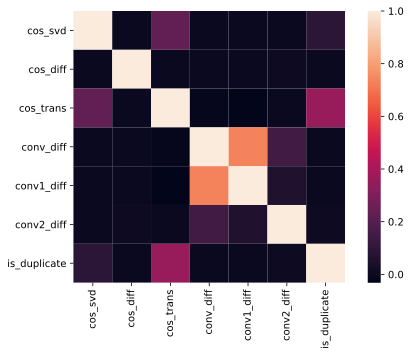

In [173]:
sns.heatmap(df_calc.corr(), square=True)

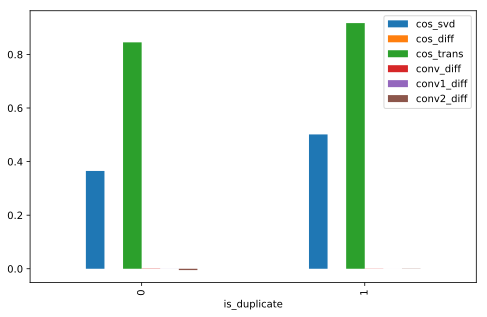

In [174]:
df_calc.groupby('is_duplicate').mean().plot.bar()#(kind='bar')

In [188]:
np.hstack([df_calc.drop(['is_duplicate'], axis=1).values, cos_svd.toarray(), q1_transform, q2_transform])

array([[ 9.75346322e-01, -7.42958193e-08,  9.79171170e-01, ...,
         1.45112491e+00,  1.27909696e+00, -3.72443825e-01],
       [ 9.66266962e-01, -1.69081474e-07,  9.09424275e-01, ...,
         1.39126039e+00,  6.42252028e-01,  5.42303920e-01],
       [-8.36463508e-01,  1.11574561e-07,  8.95228867e-01, ...,
         2.15570188e+00,  2.09787703e+00, -3.53157967e-02],
       ...,
       [ 9.85089474e-01,  9.71328831e-08,  8.86292541e-01, ...,
         9.21090007e-01, -1.18799001e-01,  8.87581944e-01],
       [-5.75995987e-01,  1.24040067e-08,  6.76746322e-01, ...,
         4.62372351e+00,  2.02116275e+00,  1.00751042e-01],
       [ 9.39436158e-01,  7.31537533e-08,  9.72957663e-01, ...,
         1.62908781e+00,  6.21410966e-01, -3.22534978e-01]])

In [181]:
df_calc.drop(['is_duplicate'], axis=1).values.shape

(404290, 6)

In [186]:
cos_svd.toarray().shape

(404290, 600)

In [189]:
X = np.hstack([df_calc.drop(['is_duplicate'], axis=1).values, cos_svd.toarray(), q1_transform, q2_transform])
y = df_train.is_duplicate.copy()

In [204]:
df_calc.head()

,cos_svd,cos_diff,cos_trans,conv_diff,conv1_diff,conv2_diff,is_duplicate
id,,,,,,,
0,0.975346,-7.429582e-08,0.979171,-0.000001,-3.959222e-12,-0.598897,0
1,0.966267,-1.690815e-07,0.909424,0.000195,1.581571e-09,2.218693,0
2,-0.836464,1.115746e-07,0.895229,-0.000026,-6.635360e-11,-0.051171,0
3,0.421034,1.343383e-07,0.620154,-0.000734,-3.670890e-08,-0.078419,0
4,-0.710030,-1.445014e-08,0.797904,-0.000308,-7.991327e-08,0.118293,0


In [ ]:
q1_red = TruncatedSVD(n_components=5).fit_transform(q1)
q2_red = TruncatedSVD(n_components=5).fit_transform(q2)
q1_tr_red = TruncatedSVD(n_components=5).fit_transform(q1_trans)
q2_tr_red = TruncatedSVD(n_components=5).fit_transform(q2_trans)

In [ ]:
q1_tfidf_red = TruncatedSVD(n_components=5).fit_transform(q1_tfidf)
q2_tfidf_red = TruncatedSVD(n_components=5).fit_transform(q2_tfidf)

In [ ]:
#X = np.hstack([q1_red, q2_red, q1_tr_red, q2_tr_red, df_calc.drop(['is_duplicate'], axis=1)])
#X = np.hstack([q1_tfidf, q2_tfidf])
X = q1_tfidf - q2_tfidf
#del q1_tfidf, q2_tfidf # q1_red, q2_red, q1_tr_red, q2_tr_red, 
gc.collect()

In [ ]:
X.shape

In [ ]:
from sklearn.preprocessing import Normalizer, MinMaxScaler

X = MinMaxScaler().fit_transform(X)

In [ ]:
X.min()

In [ ]:
gc.collect()

In [ ]:
#X = np.hstack([q1_trans, q2_trans])
#X = cos_svd

In [ ]:
y = df_train.is_duplicate.copy()

In [190]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.10, random_state=23)
#del X, y
gc.collect()

5

In [199]:
lgbm_params =  {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'max_depth': 15,
    'num_leaves': 70,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.8,
#     'bagging_freq': 5,
    'learning_rate': 0.015,
    'verbose': 0,
    'num_threads': 8
}

lgtrain = lgb.Dataset(X_train, y_train, feature_name=)
lgvalid = lgb.Dataset(X_valid, y_valid)

In [201]:
lgb_clf = lgb.train(
    lgbm_params,
    lgtrain,
    num_boost_round=400,
    valid_sets=[lgtrain, lgvalid],
    valid_names=['train','valid'],
    early_stopping_rounds=200,
    verbose_eval=200
)

Training until validation scores don't improve for 200 rounds.
[200]	train's binary_logloss: 0.470922	valid's binary_logloss: 0.480351
[400]	train's binary_logloss: 0.431436	valid's binary_logloss: 0.447803
Did not meet early stopping. Best iteration is:
[400]	train's binary_logloss: 0.431436	valid's binary_logloss: 0.447803


Text(0.5,1,'Light GBM Feature Importance')

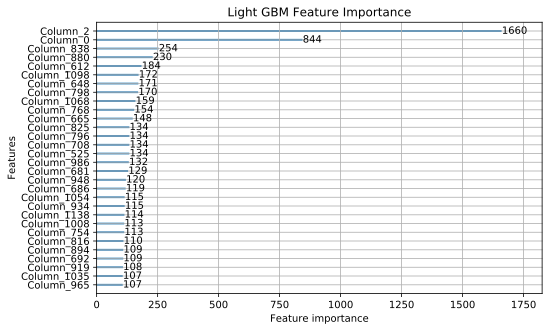

In [206]:
f, ax = plt.subplots()
lgb.plot_importance(lgb_clf, ax=ax, max_num_features=30)
plt.title("Light GBM Feature Importance")
#plt.savefig(PATH+'/feature_import.png')